<a href="https://colab.research.google.com/github/adrianoracano/Prog-NAPDE/blob/main/prova_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [3]:
!git clone https://github.com/adrianoracano/Prog-NAPDE.git

fatal: destination path 'Prog-NAPDE' already exists and is not an empty directory.


In [4]:
%cd /gdrive/My Drive/Prog-NAPDE

/gdrive/My Drive/Prog-NAPDE


In [9]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt

np.random.seed(123)
tf.random.set_seed(123)

## ODE-NN


loss: 6.805569 
loss: 1.606954 
loss: 0.346623 
loss: 0.162952 
loss: 0.104779 
loss: 0.096562 
loss: 0.096616 
loss: 0.096640 
loss: 0.096641 
loss: 0.095905 


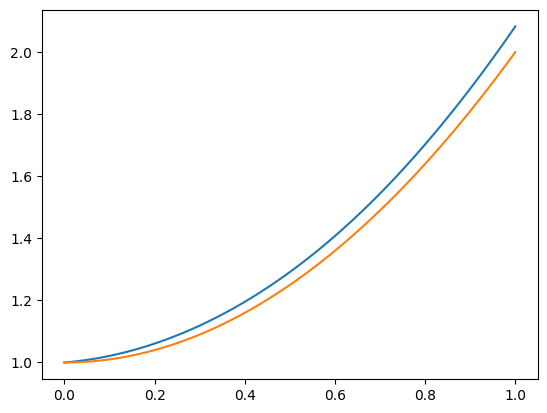

In [10]:
f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(x):
  return x * multilayer_perceptron(x) + f0
# Given EDO
def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
def custom_loss():
  summation = []
  for x in np.linspace(-1,1,10):
    dNN = (g(x+inf_s)-g(x))/inf_s
    summation.append((dNN - f(x))**2)
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))


def train_step():
  with tf.GradientTape() as tape:
    loss = custom_loss()
  trainable_variables=list(weights.values())+list(biases.values())
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))
    
    
# True Solution (found analitically)
def true_solution(x):
  return x**2 + 1
X = np.linspace(0, 1, 100)
result = []
for i in X:
  result.append(g(i).numpy()[0][0][0])
S = true_solution(X)
plt.plot(X, result)
plt.plot(X, S)
plt.show()



## Prova

loss: 0.034738 
loss: 0.034461 
loss: 0.034185 
loss: 0.033909 
loss: 0.033632 
loss: 0.033356 
loss: 0.033079 
loss: 0.032802 
loss: 0.032526 
loss: 0.032249 


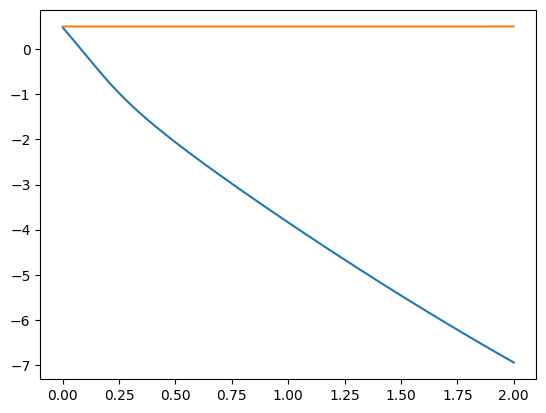

In [5]:
f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta, T):
    x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(x)
# Given EDO
tau = 365.

def beta_eq(T):
    return 1.0 - T

def T(t):
    return math.cos(t)

def dbeta(beta, t):
    return 1/tau*( beta_eq(T(t)) - beta[0] )
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=2.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N


def custom_loss():
    
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)):
        x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * multilayer_perceptron( x )
        summation.append( dt*(beta[i] - next_beta)**2 )
        curr_beta = next_beta
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")
